In [1]:
import torch
import torch.nn as nn
import scipy.ndimage

In [2]:
class HDC_Block(nn.Module):
  def __init__(self, channels):
    super().__init__()
    # my assumption was that if you wanted a convolution with 3x3x1, you couldn't have it be 3d and specify the kernel size like that
    # however, looking at the code implementation, you can do that
    self.one_one_one1 = nn.Conv3d(channels, channels, kernel_size=1, stride=1)
    self.three_three_one = nn.Conv3d(8, 8, kernel_size=(3,3,1), padding=(1,1,0))
    self.one_three_three = nn.Conv3d(channels, channels, kernel_size=(1,3,3), padding=(0,1,1))
  def forward(self, x):
    x1 = self.one_one_one1(x)
    print(x1.shape)

    # [2, 32, 64, 64, 64]

    print("channel groups")
    # split into 4
    channel_group1 = x1[:, 0:8, :, :, :] # one modality
    print(channel_group1.shape)

    channel_group2 = x1[:, 8:16, :, :, :]
    print(channel_group2.shape)

    channel_group3 = x1[:, 16:24, :, :, :]
    print(channel_group3.shape)

    channel_group4 = x1[:, 24:32, :, :, :]
    print(channel_group4.shape)

    x2 = self.three_three_one(channel_group2)
    print(x2.shape)
    x3 = self.three_three_one(channel_group3+x2)
    print(x3.shape)
    x4 = self.three_three_one(channel_group4+x3)
    print(x4.shape)

    end = torch.cat([channel_group1, x2, x3, x4], dim=1)
    print(end.shape)

    x5 = self.one_one_one1(end)
    print(x5.shape)

    out = self.one_three_three(x5)
    print(out.shape)
    return out

In [3]:
x = torch.rand(size=(2, 32, 64, 64, 64), dtype=torch.float32)
print(x.shape)

model = HDC_Block(32)
print(model)
print()

out = model(x)

torch.Size([2, 32, 64, 64, 64])
HDC_Block(
  (one_one_one1): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (three_three_one): Conv3d(8, 8, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
  (one_three_three): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
)

torch.Size([2, 32, 64, 64, 64])
channel groups
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 8, 64, 64, 64])
torch.Size([2, 32, 64, 64, 64])
torch.Size([2, 32, 64, 64, 64])
torch.Size([2, 32, 64, 64, 64])


In [4]:
class HDC_Net(nn.Module):
  def __init__(self, x):
    super().__init__()
    # self.pds = torch.nn.functional.interpolate(x)
    self.conv1 = nn.Conv3d(in_channels=4, out_channels=32, kernel_size=3, padding=1, stride=1)
    self.downsample = nn.Conv3d(32, 32, kernel_size=2, stride=2)
    self.HDC = HDC_Block(32)
    self.upsample = nn.ConvTranspose3d(32, 32, kernel_size=2, stride=2)
    self.upinterpolate = nn.Upsample(scale_factor=2, mode='trilinear')
    self.conv2 = nn.Conv3d(in_channels=32, out_channels=3, kernel_size=1, stride=1)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, x):
    print(x.shape)
    nimages, channels, width, height, depth = x.shape
    print(nimages, channels, width, height, depth)
    print(x.type)
    # x1 = torch.tensor(scipy.ndimage.zoom(x, [1, 8.0, 0.5, 0.5, 0.5])) # using this function took about 2 minutes and for many images, it's not reasonable
    x1 = torch.nn.functional.interpolate(x, scale_factor=[0.5, 0.5, 0.5]) # PDS - interpolate only looks at dim 2,3,4... (doesn't regard for channel and number of images)
    # instead, I used torch.nn.functional.interpolate to interpolate the spatial dimensions, but for the channels I used a 1x1x1 conv
    # because they did want to avoid using 3x3x3 conv and it will work same
    print(x1.shape)
    x1 = self.conv1(x1)
    print(x1.shape)

    x2 = self.HDC(x1)
    print(x2.shape)
    print()
    x3 = self.downsample(x2)
    print(x3.shape)

    x4 = self.HDC(x3)
    print(x4.shape)
    print()
    x5 = self.downsample(x4)
    print(x5.shape)

    x6 = self.HDC(x5)
    print(x6.shape)
    print()
    x7 = self.downsample(x6)
    print(x7.shape)

    x8 = self.HDC(x7)
    print(x8.shape)
    print()

    print("decoder time")

    x9 = self.upsample(x8)
    print(x9.shape)
    x10 = torch.add(x9, x6)
    print(x10.shape)
    x11 = self.HDC(x10)
    print(x11.shape)

    x12 = self.upsample(x11)
    print(x12.shape)
    x13 = torch.add(x12, x4)
    print(x13.shape)
    x14 = self.HDC(x13)
    print(x14.shape)

    x15 = self.upsample(x14)
    print(x15.shape)
    x16 = torch.add(x15, x2)
    print(x16.shape)
    x17 = self.HDC(x16)
    print(x17.shape)

    print("\nupsampling\n") # by this they meant interpolation

    x18 = self.upinterpolate(x17)
    print(x18.shape)

    x19 = self.conv2(x18)
    print(x19.shape)

    out = self.softmax(x19)
    print(out.shape)

    return x19, out

In [5]:
x = torch.rand(size=(2, 4, 128, 128, 128), dtype=torch.float32)
print(x.shape)

model = HDC_Net(x)
print(model)
print()

# out = model(x)
# print(out.shape)

torch.Size([2, 4, 128, 128, 128])
HDC_Net(
  (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (downsample): Conv3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (HDC): HDC_Block(
    (one_one_one1): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (three_three_one): Conv3d(8, 8, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (one_three_three): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
  (upsample): ConvTranspose3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (upinterpolate): Upsample(scale_factor=2.0, mode=trilinear)
  (conv2): Conv3d(32, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (softmax): Softmax(dim=1)
)



In [6]:
# output, probability = out

In [7]:
# print(output.shape)
# print(output)

In [8]:
# print(probability.shape)
# print(probability)

In [9]:
import numpy as np

In [10]:
randomized_training_images = []
for i in range(2):
  newx = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_training_images.append(newx)

In [11]:
print(len(randomized_training_images))
print(randomized_training_images[0].shape)
# print(randomized_training_images[0])

2
torch.Size([1, 4, 128, 128, 128])


In [12]:
randomized_training_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_training_segmentations.append(newy)

In [13]:
print(len(randomized_training_segmentations))
print(randomized_training_segmentations[0].shape)
# print(randomized_training_segmentations[1])

2
torch.Size([1, 3, 128, 128, 128])


In [14]:
randomized_training_data = list(zip(randomized_training_images, randomized_training_segmentations))

In [15]:
trainloader = torch.utils.data.DataLoader(dataset=randomized_training_data, batch_size=2, shuffle=True) # batch size should be 10

In [16]:
len(trainloader)

1

In [17]:
randomized_validation_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_validation_images.append(newy)

In [18]:
print(len(randomized_validation_images))
print(randomized_validation_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [19]:
randomized_validation_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_validation_segmentations.append(newy)

In [20]:
print(len(randomized_validation_segmentations))
print(randomized_validation_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [21]:
randomized_validation_data = list(zip(randomized_validation_images, randomized_validation_segmentations))

In [22]:
validationloader = torch.utils.data.DataLoader(dataset=randomized_validation_data, batch_size=2, shuffle=True) # batch size should be 10

In [23]:
len(validationloader)

1

In [24]:
randomized_testing_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_testing_images.append(newy)

In [25]:
print(len(randomized_testing_images))
print(randomized_testing_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [26]:
randomized_testing_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_testing_segmentations.append(newy)

In [27]:
print(len(randomized_testing_segmentations))
print(randomized_testing_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [28]:
randomized_testing_data = list(zip(randomized_testing_images, randomized_testing_segmentations))

In [29]:
testingloader = torch.utils.data.DataLoader(dataset=randomized_testing_data, batch_size=2, shuffle=True) # batch size should be 10

In [30]:
"""
Training + Validation:
multi-class soft Dice function as the loss function

Testing:
mean accuracy
dice coefficient
hausdorff implementation
"""

'\nTraining + Validation:\nmulti-class soft Dice function as the loss function\n\nTesting:\nmean accuracy\ndice coefficient\nhausdorff implementation\n'

In [31]:
# chose to make this a class because when you call dice loss in criterion, you don't have anything to input, but when u run the prediction through inside the training, then you have params
# also because most sources I saw used a class
class DiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.smooth = 1
  def forward(self, true, pred):
    # flatten to easily do it pixel by pixel
    true = true.view(-1)
    pred = pred.view(-1)
    numerator = 2*(true*pred).sum()
    denominator = true.sum() + pred.sum()
    dice_loss = 1 - (numerator + self.smooth) / (denominator + self.smooth)
    return dice_loss

In [32]:
import torch.optim

In [33]:
# epochs
epochs = 2 # should be 800
# loss
criterion = DiceLoss()
# optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=10**-3, weight_decay=10**-5)

In [34]:
import datetime

In [ ]:
training_losses = []
validation_losses = []

for i in range(epochs): # for every epoch
  start_epoch = datetime.datetime.now() # start the timer in datetime module
  training_loss = 0 # training loss for this epoch
  validation_loss = 0 # validation loss for this epoch
  print("training time")
  for images, segs in trainloader: # getting one batch from trainloader
    optimizer.zero_grad() # turn on gradients (used for forward and backprop)
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    # need to squeeze the 1 in first dimension
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)
    outputs, softmax_outputs = model(images) # put images through model
    print(outputs.shape)
    print(softmax_outputs.shape)

    # arg_outputs = outputs.argmax(dim=1)
    # print(arg_outputs.shape)
    # print(arg_outputs)
    # print(segs.shape)
    print()
    loss = criterion(softmax_outputs.float(), segs)
    print(loss) # loss with random tensors will be really high because none of the tensors are related to each other
    
    loss.backward() # back propagation
    training_loss += loss.item() # add loss to training loss
    print()
  print("validation time")

  for images, segs in validationloader: # getting one batch from validationloader
    optimizer.zero_grad() # keep gradients on (used for forward and backprop)
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    # need to squeeze the 1 in first dimension
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)
    outputs, softmax_outputs = model(images) # put images through model
    print(outputs.shape)
    print(softmax_outputs.shape)
    loss = criterion(softmax_outputs.float(), segs) # calculate loss
    print(loss) # loss with random tensors will be really high because none of the tensors are related to each other
    loss.backward() # backpropagation
    validation_loss += loss.item() # add loss to validation loss
  
  # find avg losses for each image
  training_losses.append(training_loss/len(trainloader))
  validation_losses.append(validation_loss/len(validationloader))

  # print results about epoch
  print("Epoch: {}/{}... Training Loss: {}... Validation Loss: {}...".format(i+1,epochs, training_losses[-1], validation_losses[-1]))
  if validation_loss < min(validation_losses):
    print("Validation loss has decreased...saving model")
    torch.save(model.state_dict(), "fcn.pth")

  # end timer
  end_epoch = datetime.datetime.now()
  # calculate and print out time it takes for every epoch
  time_epoch = end_epoch-start_epoch
  print("Epoch time:", str(time_epoch), "\n")
  print()

In [36]:
print(training_losses)
print(validation_losses)

[0.5999975800514221, 0.5999975800514221]
[0.5999869108200073, 0.5999869108200073]


In [37]:
import matplotlib.pyplot as plt

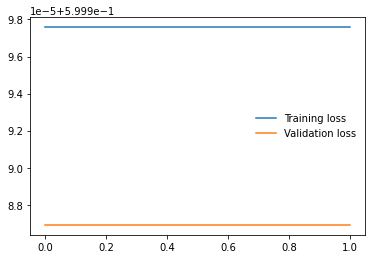

In [38]:
# visualize losses
plt.plot(training_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend(frameon=False)

In [39]:
def dice_score(outputs, segmentations): # they find individual
  # outputs = torch.Size([2, 3, 128, 128, 128])
  # segmentations = torch.Size([2, 3, 128, 128, 128])
  # print(outputs.shape)
  # print(segmentations.shape)
  n_classes = segmentations.shape[1]
  region_dice_scores = []
  for i in range(n_classes):
    outputs = outputs.view(-1)
    segmentations = segmentations.view(-1)
    numerator = 2*(outputs*segmentations).sum()
    denominator = outputs.sum() + segmentations.sum()
    dice = (numerator) / (denominator)
    region_dice_scores.append(dice)
  return region_dice_scores

In [40]:
"""
1 NECROTIC TUMOUR CORE (NCR — label 1) - index 0

2 GD-ENHANCING TUMOUR (ET — label 2) - index 1

3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3) - index 2
"""

'\n1 NECROTIC TUMOUR CORE (NCR — label 1) - index 0\n\n2 GD-ENHANCING TUMOUR (ET — label 2) - index 1\n\n3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3) - index 2\n'

In [41]:
import math

In [42]:
from scipy.spatial.distance import directed_hausdorff

In [43]:
def hausdorff(outputs, segmentations): # for region for every image
  # print(outputs.shape)
  # print(segmentations.shape)

  # for each image in batch
  h_imgs = [0,0,0]
  len_imgs = len(outputs)

  for idx in range(len_imgs): # for each image
    out = outputs[idx]
    seg = segmentations[idx]
    n_classes = out.shape[0]
    # print(n_classes)

    region_hd_scores = []
    for i in range(n_classes): # for each class
      region_out = out[i]
      region_seg = seg[i]
      # print(region_out.shape)
      # print(region_seg.shape)

      # print()
      total_hd_image = 0
      for j in range(region_out.shape[0]): # for each slice
        out_slice = region_out[j]
        seg_slice = region_seg[j]
        # print(out_slice.shape)
        # print(seg_slice.shape)
        a = directed_hausdorff(out_slice, seg_slice)[0]
        b = directed_hausdorff(seg_slice, out_slice)[0]
        hd_slice = max(a, b)
        total_hd_image += hd_slice
      avg_hd_image = total_hd_image/region_out.shape[0]
      # print(avg_hd_image)
      region_hd_scores.append(avg_hd_image)
    # print(region_hd95_scores)
    h_imgs[0] += region_hd_scores[0]
    h_imgs[1] += region_hd_scores[1]
    h_imgs[2] += region_hd_scores[2]
  
  for each in range(len(h_imgs)):
    h_imgs[each] = h_imgs[each]/len_imgs
  
  print(h_imgs)

  return h_imgs

In [ ]:
for images, segs in testingloader:
    with torch.no_grad(): # no gradients (there's no backprop, only evaluation)
      print(len(images), len(segs))
      print(images.shape)
      print(segs.shape)
      # exclude first dimension of 1
      images = images.squeeze().clone().detach().requires_grad_(True)
      # segs = segs.long() - no
      segs = segs.squeeze().clone().detach().requires_grad_(True)
      print(images.shape)
      print(segs.shape)
      outputs, softmax_outputs = model(images) # put images through model
      print(outputs.shape)
      print(softmax_outputs.shape)
      print()

      print("\n", "......."*5, "\n")

      region_dice_scores = dice_score(softmax_outputs, segs)

      print(len(region_dice_scores))
      print(region_dice_scores)
      print()

      print("1 NECROTIC TUMOUR CORE (NCR — label 1)")
      print(region_dice_scores[0].item())
      print()

      print("2 GD-ENHANCING TUMOUR (ET — label 2)")
      print(region_dice_scores[1].item())
      print()

      print("3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3)")
      print(region_dice_scores[2].item())

      print("\n", "......."*5, "\n")

      hd_scores = hausdorff(softmax_outputs, segs)

      print()
      print(len(hd_scores))
      print(hd_scores)
      print()

      print("1 NECROTIC TUMOUR CORE (NCR — label 1)")
      print(hd_scores[0])
      print()

      print("2 GD-ENHANCING TUMOUR (ET — label 2)")
      print(hd_scores[1])
      print()

      print("3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3)")
      print(hd_scores[2])